In [1]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Загрузка данных и их анализ 

In [2]:
data = pd.read_csv('RFM_ht_data.csv')

In [3]:
data.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     332730 non-null  object 
 1   CustomerCode  332730 non-null  object 
 2   InvoiceDate   332730 non-null  object 
 3   Amount        332730 non-null  float64
dtypes: float64(1), object(3)
memory usage: 10.2+ MB


Приведем колонки InvoiceNo, CustomerCode, InvoiceDate к корректным форматам

In [5]:
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)

In [6]:
data.InvoiceNo = data.InvoiceNo.astype('string')

In [7]:
data.CustomerCode = data.CustomerCode.astype('string')

Найдем самую раннюю и самую позднюю дату в датасете

In [8]:
first_date = data.InvoiceDate.min()

In [9]:
last_date = data.InvoiceDate.max()

In [10]:
print('Minimum date: {:%Y-%m-%d}.  Maximum date: {:%Y-%m-%d}.'.format(first_date, last_date))


Minimum date: 2020-09-01.  Maximum date: 2020-09-30.


Найдем количество заказов, сделанных каждым пользователем

In [11]:
num_orders = data.groupby('CustomerCode', as_index=False).agg({'InvoiceNo':'count'}).sort_values('InvoiceNo')
num_orders.head()

,CustomerCode,InvoiceNo
0,02213019,1
67249,18053075,1
67247,18053072,1
67245,18053055,1
67243,18053019,1


## RFM-анализ

Для дальнейшего присваивания скора посчитаем количество дней с последней покупки, количество заказов и общую сумму по всем заказам клиента

In [12]:
rfm = (data
             .groupby('CustomerCode', as_index=False)
             .agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # R - Количество дней с последней покупки 
                   'InvoiceNo': lambda x: len(x), # F - количество заказов, сделанных пользователем
                   'Amount': lambda x: x.sum()})) # M - общая сумма по всем заказам

In [13]:
data.CustomerCode.nunique()

123733

In [14]:
rfm.rename(columns={'InvoiceDate':'recency',
                         'InvoiceNo':'frequency',
                         'Amount': 'monetary'}, inplace=True)

In [15]:
rfm.head()

,CustomerCode,recency,frequency,monetary
0,02213019,19,1,1609.20
1,02213042,22,3,9685.48
2,02213071,29,1,415.00
3,02213088,23,1,305.00
4,02213092,25,1,1412.88


In [16]:
rfm.shape

(123733, 4)

Для определения границ построим графики распределения для resency, frequency, monetary

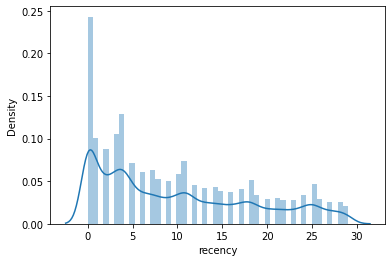

In [17]:
# распределение resency
sns.distplot(rfm.recency)

In [18]:
rfm.recency.describe()

count    123733.000000
mean          9.797742
std           8.560802
min           0.000000
25%           2.000000
50%           8.000000
75%          16.000000
max          29.000000
Name: recency, dtype: float64

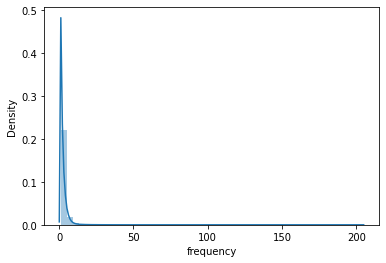

In [19]:
# распределение frequency
sns.distplot(rfm.frequency)

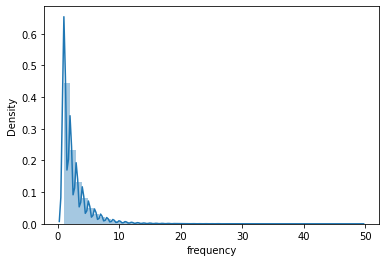

In [20]:
sns.distplot(rfm[rfm['frequency']<50]['frequency'])

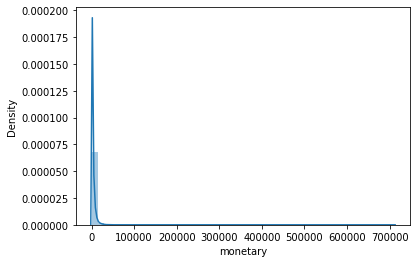

In [21]:
# распределение monetary
sns.distplot(rfm.monetary)

In [22]:
rfm.monetary.describe()

count    123733.000000
mean       3331.870758
std        6131.418681
min         -80.000000
25%         765.000000
50%        1834.480000
75%        4008.840000
max      711487.710000
Name: monetary, dtype: float64

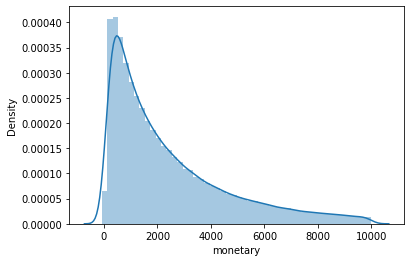

In [23]:
sns.distplot(rfm[rfm['monetary']<10_000]['monetary'])

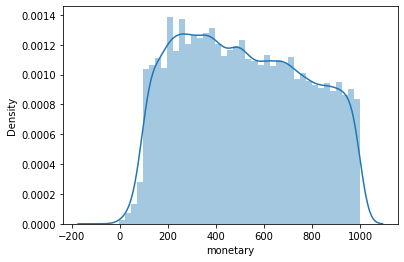

In [24]:
sns.distplot(rfm[rfm['monetary']<1000]['monetary'])

### Границы и значения подсегментов

**Resency:** 
- "1" присваивается всем клиентам, у которых количество дней от последней покупки более 16.
- "2" присваивается всем клиентам, у которых количество дней от последней покупки меньше или равно 16, но более 5 дней
- "3" присваивается всем клиентам, у которых количество дней не больше 5 дней

**Frequency:** 
- "1" присваивается всем клиентам, которые совершили покупку не более 3 раз.
- "2" присваивается всем клиентам, которые совершили больше 3х раз, но не больше 12 раз 
- "3" присваивается всем клиентам, которые совершили покупку больше 12 раз

**Monetary:** 
- "1" присваивается всем клиентам, которые совершили покупку не более чем на 200 фунтов.
- "2" присваивается всем клиентам, которые совершили более чем на 200, но меньше чем на 2000 фунтов.
- "3" присваивается всем клиентам, которые совершили более чем на 2000 фунтов


In [25]:
def Rclass(value):
    if value <= 5:
        return 3
    elif (value > 5) and (value <= 16):
        return 2
    else:
        return 1

def Fclass(value):
    if value <= 3:
        return 1
    elif (value > 3) and (value <= 12) :
        return 2
    else:
        return 3
    
def Mclass(value):
    if value <= 200:
        return 1
    elif (value > 200) and (value <= 2000) :
        return 2
    else:
        return 3

In [26]:
rfm = rfm

In [27]:
rfm['R'] = rfm['recency'].apply(Rclass)
rfm['F'] = rfm['frequency'].apply(Fclass)
rfm['M'] = rfm['monetary'].apply(Mclass)

Создаем столбец с результирующими сегментами (RFMclass) и строим распределения количества покупателей по сегментам

In [28]:
rfm['RFMclass'] = rfm.R.map(str) + rfm.F.map(str) + rfm.M.map(str)

In [29]:
rfm.head()

,CustomerCode,recency,frequency,monetary,R,F,M,RFMclass
0,02213019,19,1,1609.20,1,1,2,112
1,02213042,22,3,9685.48,1,1,3,113
2,02213071,29,1,415.00,1,1,2,112
3,02213088,23,1,305.00,1,1,2,112
4,02213092,25,1,1412.88,1,1,2,112


Text(1.0, 1.0, 'Распределение количества пользователей по каждому подсегменту')

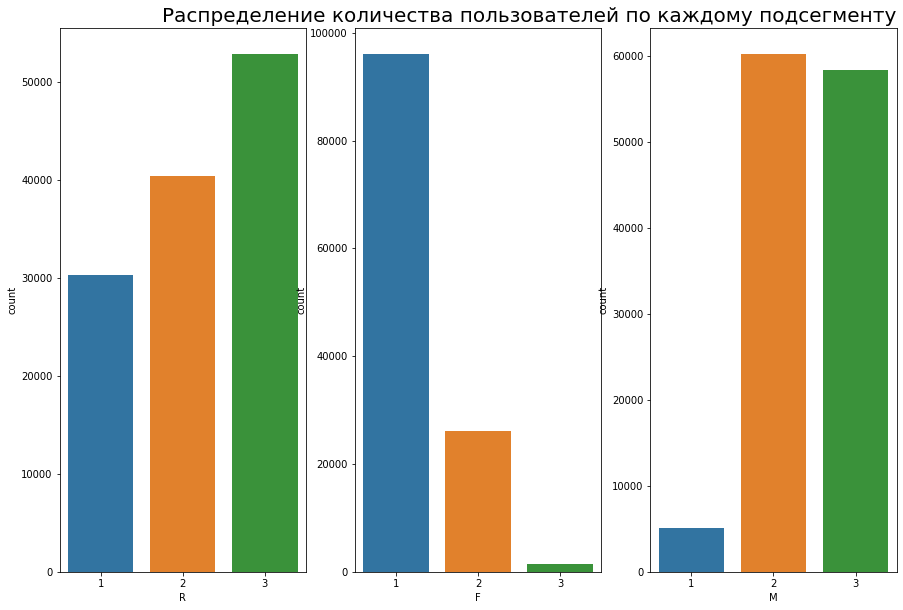

In [43]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1); sns.countplot(rfm.R)

plt.subplot(1, 3, 2); sns.countplot(rfm.F)
    
plt.subplot(1, 3, 3); sns.countplot(rfm.M)

plt.title("Распределение количества пользователей по каждому подсегменту",
         fontsize=20,
         loc="right") 

Text(0.5, 1.0, 'Распределение количества пользователей по сегментам')

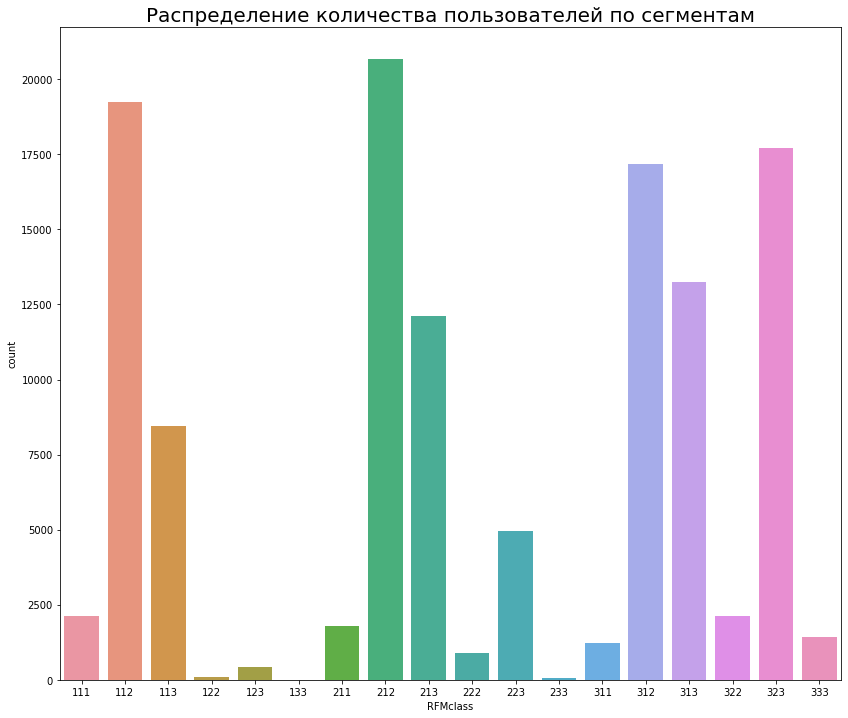

In [33]:
plt.figure(figsize=(14,12))
sns.countplot(rfm.RFMclass.sort_values())
plt.title("Распределение количества пользователей по сегментам",
         fontsize=20) 

### Выводы:
- 111, 112, 113 - потеряные покупатели. Их достаточно много, нужно поработать над удержанием этих клиентов. Например, можно попытаться донести ценность нашего продукта, но с помощью недорогих инструментов.
- 122, 123, 133 - активные покупателей, которые ушли достаточно мало, это хороший показатель. Тем, кто все же ушел можно напомнить о покупке или предложить скидку.
- 211, 311 - клиенты с маленькой суммой покупок. Для повышения среднего чека им можно предложить сопутствующие товары или рекомендации на основе покупок других пользователей.
- 212, 212, 311, 312, 313 - это новые покупатели, они совершили не много покупок и не так давно. Нам нужно заинтересовать и удержать этих клиентов, для этого можно постараться больше рассказать о продукте, собрать фидбек, возможно, предложить программу лояльности. 
- 222, 223 - клиенты, которые делают покупки редко, но на большие суммы. Скорее всего, какие-то постоянные корпоративные клиенты.
- 322, 232, 333 - это наши постоянные клиенты, которые покупают регулярно и часто, у них довольно высокий средний чек. Им также можно предложить программу лояльности. Кроме того будет полезно выявить какие ценности продукта для них ключевые и поддерживать их.